### Hyperparameters:
| Hyperparameter       | Value   |
|----------------------|---------|
| num-filters          | 32      |
| num-bilstm-layer     | 2       |
| output-lstm-dim      | 64      |
| decay-rate           | 0.8     |
| learning-rate        | 0.01    |
| miniBatchSize        | 256     |
| filter-size          | 10 × 1  |
| input-lstm-dim       | 100     |
| L2Regularization     | 0.001   |
| optimizer            | Adam    |
| dropout              | 0.25    |
| maxEpochs            | 500     |

In [1]:
import sys
sys.path.append("..")

In [104]:
from tqdm import tqdm
import pandas as pd
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from utils.helper import *

In [148]:
df = pd.read_csv("../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])

K = 7
df = scaled_data_vmd(df, _K=K)

target_col = "Price"
features = [col for col in df.columns if col != target_col and col != "Date"]

seq_len = 15
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

In [149]:
batch_size = 256

train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)

In [150]:
input, target = next(iter(train_loader))

print(f"Input shape: {input.shape}")
print(f"Target shape: {target.shape}")

Input shape: torch.Size([256, 15, 112])
Target shape: torch.Size([256])


## CNN-BiLSTM

In [151]:
class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, num_filters=32, num_bilstm_layers=2, lstm_hidden=64, filter_size=(10, 1), input_lstm_dim=100, dropout_rate=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels=input_dim,
            out_channels=num_filters,
            kernel_size=filter_size[0],
            stride=1,
            padding=filter_size[0] // 2
        )

        self.proj = nn.Linear(num_filters, input_lstm_dim)

        self.relu = nn.ReLU()

        self.bilstm1 = nn.LSTM(
            input_size=input_lstm_dim,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.drop1 = nn.Dropout(dropout_rate)

        self.bilstm2 = nn.LSTM(
            input_size = 2 * lstm_hidden,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(lstm_hidden * 2, 1)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))

        x = x.permute(0, 2, 1)
        x = self.relu(self.proj(x))

        # BiLSTM layers
        out, _ = self.bilstm1(x)
        out = self.drop1(out)
        out, _ = self.bilstm2(out)

        # take last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)

In [152]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [153]:
model = CNNBiLSTM(input_dim=len(features))

In [154]:
decay_rate = 0.8
num_epochs = 500
learning_rate = 0.001
l2_penalty = 0.001

In [155]:
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    # weight_decay=l2_penalty
)

# scheduler = torch.optim.lr_scheduler.ExponentialLR(
#     optimizer,
#     gamma=decay_rate
# )
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=decay_rate
)

In [156]:
best_val_loss = float('inf')
patience = 10
patience_counter = 0

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    model.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # scheduler.step()

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # torch.save(model.state_dict(), '../models/cnn_bilstm15.pth')
    else:
        patience_counter += 1

    # if epoch % 10 == 0 or epoch == num_epochs - 1:
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

print(f'\nBest validation loss: {best_val_loss:.6f}')

Training on device: mps
Model parameters: 223621
Epoch 1/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 127.36it/s]


Epoch [1/500] - Train Loss: 1.253129, Val Loss: 19.043070
Epoch 2/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 161.64it/s]


Epoch [2/500] - Train Loss: 0.887941, Val Loss: 14.737773
Epoch 3/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 107.29it/s]


Epoch [3/500] - Train Loss: 0.565851, Val Loss: 9.907017
Epoch 4/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 150.51it/s]


Epoch [4/500] - Train Loss: 0.424377, Val Loss: 6.311080
Epoch 5/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 151.61it/s]


Epoch [5/500] - Train Loss: 0.252958, Val Loss: 4.665098
Epoch 6/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 155.46it/s]


Epoch [6/500] - Train Loss: 0.129582, Val Loss: 2.061738
Epoch 7/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 161.40it/s]


Epoch [7/500] - Train Loss: 0.061774, Val Loss: 1.284624
Epoch 8/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 161.79it/s]


Epoch [8/500] - Train Loss: 0.029088, Val Loss: 0.813154
Epoch 9/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 142.18it/s]


Epoch [9/500] - Train Loss: 0.046584, Val Loss: 0.289509
Epoch 10/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 111.36it/s]


Epoch [10/500] - Train Loss: 0.223369, Val Loss: 3.716058
Epoch 11/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 138.00it/s]


Epoch [11/500] - Train Loss: 0.055610, Val Loss: 0.394440
Epoch 12/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 155.30it/s]


Epoch [12/500] - Train Loss: 0.089454, Val Loss: 1.343926
Epoch 13/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 141.17it/s]


Epoch [13/500] - Train Loss: 0.069742, Val Loss: 0.559325
Epoch 14/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 136.87it/s]


Epoch [14/500] - Train Loss: 0.040333, Val Loss: 0.686270
Epoch 15/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 127.54it/s]


Epoch [15/500] - Train Loss: 0.013470, Val Loss: 0.361499
Epoch 16/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 157.67it/s]


Epoch [16/500] - Train Loss: 0.011368, Val Loss: 0.330789
Epoch 17/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 138.95it/s]


Epoch [17/500] - Train Loss: 0.010242, Val Loss: 0.394923
Epoch 18/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 132.89it/s]


Epoch [18/500] - Train Loss: 0.006960, Val Loss: 0.278761
Epoch 19/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 149.18it/s]


Epoch [19/500] - Train Loss: 0.005303, Val Loss: 0.312382
Epoch 20/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 141.79it/s]


Epoch [20/500] - Train Loss: 0.003684, Val Loss: 0.284563
Epoch 21/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 139.82it/s]


Epoch [21/500] - Train Loss: 0.003780, Val Loss: 0.260445
Epoch 22/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 159.63it/s]


Epoch [22/500] - Train Loss: 0.003610, Val Loss: 0.291906
Epoch 23/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 142.85it/s]


Epoch [23/500] - Train Loss: 0.003538, Val Loss: 0.263640
Epoch 24/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 143.72it/s]


Epoch [24/500] - Train Loss: 0.004288, Val Loss: 0.294015
Epoch 25/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 133.07it/s]


Epoch [25/500] - Train Loss: 0.005903, Val Loss: 0.242741
Epoch 26/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 149.30it/s]


Epoch [26/500] - Train Loss: 0.009753, Val Loss: 0.375704
Epoch 27/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 135.42it/s]


Epoch [27/500] - Train Loss: 0.019940, Val Loss: 0.310210
Epoch 28/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 152.32it/s]


Epoch [28/500] - Train Loss: 0.028061, Val Loss: 0.644282
Epoch 29/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 138.36it/s]


Epoch [29/500] - Train Loss: 0.014843, Val Loss: 0.274011
Epoch 30/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 146.50it/s]


Epoch [30/500] - Train Loss: 0.008698, Val Loss: 0.384769
Epoch 31/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 155.35it/s]


Epoch [31/500] - Train Loss: 0.004998, Val Loss: 0.250308
Epoch 32/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 159.30it/s]


Epoch [32/500] - Train Loss: 0.003880, Val Loss: 0.290016
Epoch 33/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 55.42it/s]


Epoch [33/500] - Train Loss: 0.002993, Val Loss: 0.269461
Epoch 34/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 120.22it/s]


Epoch [34/500] - Train Loss: 0.003600, Val Loss: 0.261294
Epoch 35/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 150.53it/s]

Epoch [35/500] - Train Loss: 0.003268, Val Loss: 0.298390
Early stopping triggered after epoch 35

Best validation loss: 0.242741


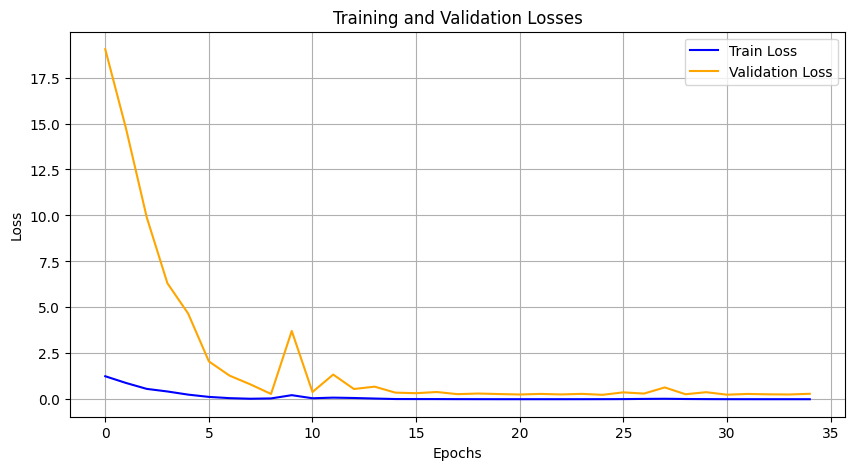

In [157]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

In [158]:
# Test phase
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# Convert to numpy arrays for analysis
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

Test Loss: 0.422387


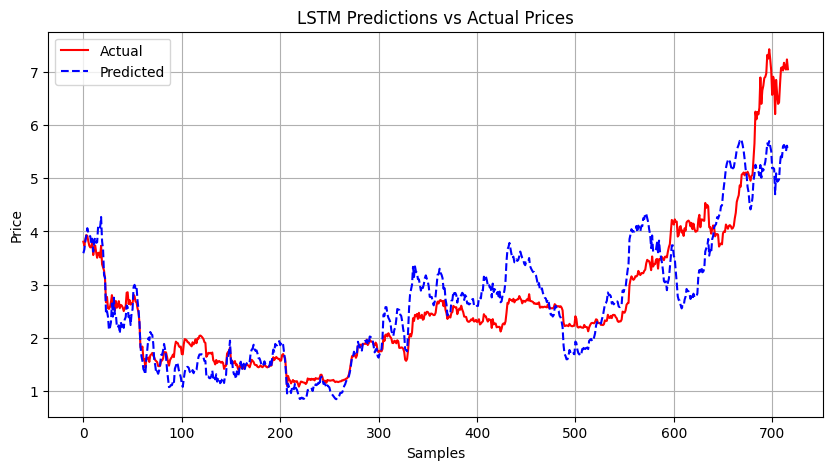

In [147]:
# plot predictions vs targets
plt.figure(figsize=(10, 5))
plt.plot(test_targets, label='Actual', color='red')
plt.plot(test_predictions, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('LSTM Predictions vs Actual Prices')
plt.legend()
plt.grid()
plt.show()